In [1]:
%matplotlib widget
import time

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from src.v2.impl.conditions import StepCountCondition, PrecisionCondition, AbsolutePrecisionCondition, EpochCountCondition
from src.v2.impl.function_interpretations import LinearInterpretation, PolynomialInterpretation, MultiLinearInterpretation, HyperbolicInterpretation
from src.v2.impl.loss_functions import MSE, LineBinary
from src.v2.impl.methods import CoordinateDescent, GoldenRatioMethod, NewtonWolfe, GradientDescentSheduled, GradientDescentBase
from src.v2.impl.metrics import StepCount, CallCount, GradientCallCount, HessianCallCount, PrecisionCount, \
    AbsolutePrecisionCount, AbsolutePrecision, MinAbsolutePrecision, RAMSize, ExecutionTime, EpochCount, LossValue
from src.v2.impl.oraculs import LambdaOracul, SymbolOracul, MinimisingOracul
from src.v2.runner.debug import FULL_DEBUG
from src.v2.runner.runner import Runner, FULL_VISUALIZE, NO_VISUALIZE, FULL_ANIMATION, VISUALIZE_FUNCTION, VISUALIZE
from src.v2.visualization.animation import Animator
from src.v2.runner.runner import TABLE
from src.v2.impl.methods import GradientDescent, ScipyMethod, Newton, NewtonBase
from IPython.display import display, HTML

display(HTML("<style>pre { white-space: pre !important; }</style>"))


def print_points(data):
    for i in data:
        print(i[0] + i[1])

In [88]:
metrics_base = [CallCount(), GradientCallCount(), LossValue()]

minPrec = 1e-5
defPrec = 1e-9
maxPrec = 1e-11

animations = [Animator()]

conditions = [StepCountCondition(100)]

modules = ([ExecutionTime()]
           + [RAMSize()]
           + [EpochCount()]
           + metrics_base
           + conditions
           + [Animator()]
           )
methods = [GradientDescent(learning_rate=100, aprox_dec=1e-11)]
point = np.array([10.2, 32.5, 2.0])

Для начала зададим генератор для порождения простейших данных. Данная функция призвана генерировать набор точек, согласно заданной функции, зашумляя данные. Именно на предоставленных ей массивах будет тестироваться базовая работоспособность и вычислительная эффективность функций

In [3]:
def noised_data_generator(func, num, begin, end, noise_range) :
    res = []
    for i in range(0, num):
        point = random.uniform(begin, end)
        res += [[point, func(point) + random.uniform(-noise_range, noise_range)]]
    return res

In [4]:
linear_data = noised_data_generator(lambda x: 6*x+10, 100, -1000, 1000, 1000)
sq_data = noised_data_generator(lambda x: 6*x**2+10*x+1, 100, -1000, 1000, 1000)

**Первый подпункт основного задания** предполагает исследование изменений в поведении метода SGD в зависимости от параметра batch_size. Для демонстрации как данной изменчивости, так и работоспособности алгоритма на практике (не стоит забывать, что его работа носит вероятностный характер, в отличие от метода градиентного спуска) рассмотрение данных особенностей будет происходить на реализованной силами данной команды реализации SGD, в силу наибольшей её приближённости к академическому представлению работы данного метода, что позволяет рассматривать подобные аспекты вне контекста практических приложений (таких как особенности работы в рамках обучения именно нейросетевых моделей, как в библиотеке tensorflow, использующейся в специфических разделах даной работы)

In [86]:
point = np.array([10.2, 32.5, 2.0])
linear_min_oracul = MinimisingOracul(MSE(), LinearInterpretation(), linear_data, 1)
linear_oracul = MinimisingOracul(MSE(), LinearInterpretation(), linear_data, 20)
linear_max_oracul = MinimisingOracul(MSE(), LinearInterpretation(), linear_data, len(linear_data))
polynomial_min_oracul = MinimisingOracul(MSE(), PolynomialInterpretation(), sq_data, 1)
polynomial_oracul = MinimisingOracul(MSE(), PolynomialInterpretation(), sq_data, 20)
polynomial_max_oracul = MinimisingOracul(MSE(), PolynomialInterpretation(), sq_data, len(sq_data))



MinimisingOracul
+--------------------------------------------------+-----------------+--------------+--------------+-------------+---------------------+-------------+
| Method name                                      |   ExecutionTime | RAMSize      |   EpochCount |   CallCount |   GradientCallCount |   LossValue |
+==================================================+=================+==============+==============+=============+=====================+=============+
| GradientDescent(100,GoldenRatioMethod,eps=1e-11) |           1.107 | 0.0234375 Mb |            2 |       19435 |                 299 |      805254 |
+--------------------------------------------------+-----------------+--------------+--------------+-------------+---------------------+-------------+

MinimisingOracul
+--------------------------------------------------+-----------------+-----------+--------------+-------------+---------------------+-------------+
| Method name                                      |   Execut

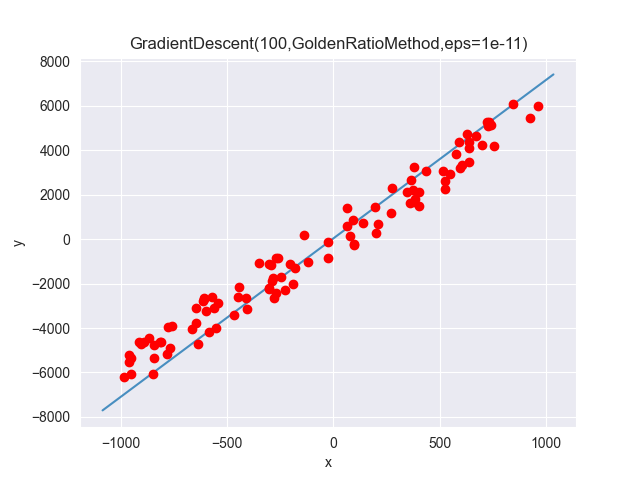

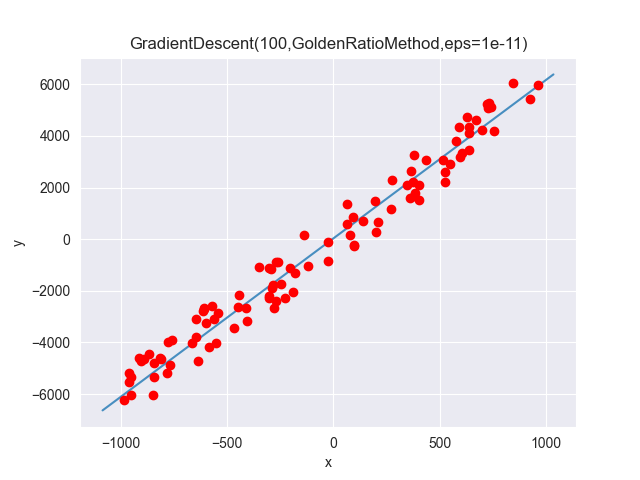

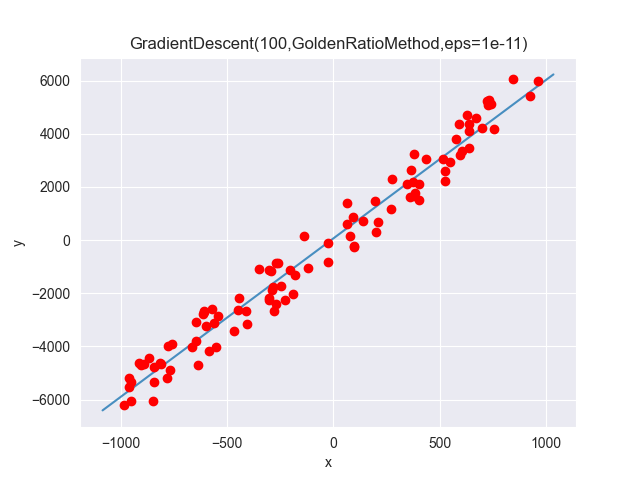

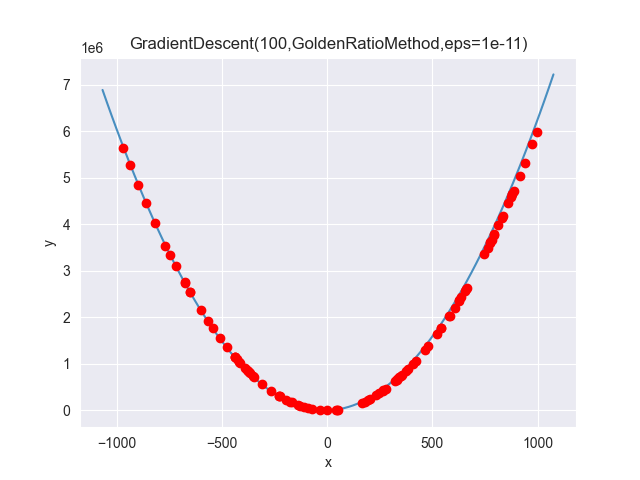

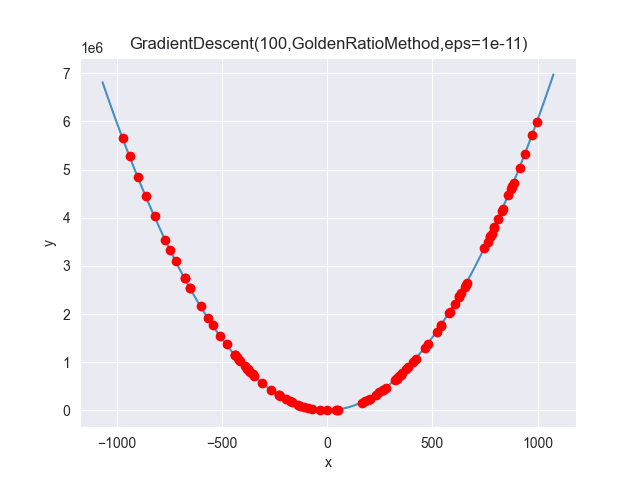

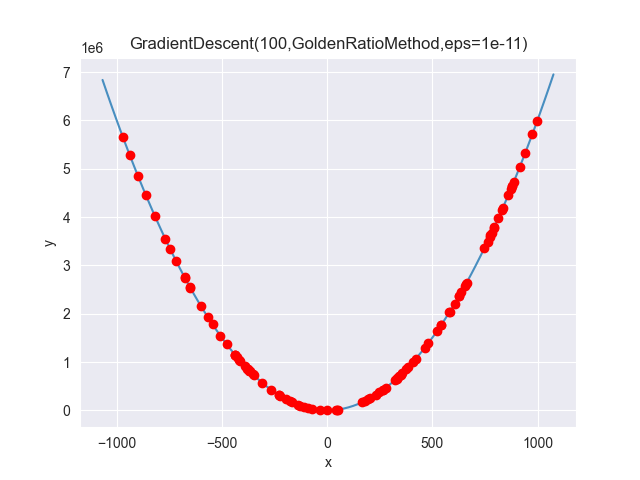

In [87]:
st = time.time()
result = Runner.run(methods, [linear_min_oracul, linear_oracul, linear_max_oracul, polynomial_min_oracul, polynomial_oracul, polynomial_max_oracul], point, modules, precision=defPrec,
                 # **FULL_DEBUG,
                 **TABLE,
                 **VISUALIZE,
                 # **FULL_VISUALIZE,
                 # **FULL_ANIMATION,
                 **VISUALIZE_FUNCTION
                 )

print(time.time() - st)

Поведение метода в целом соответствует ожиданиям. При минимальном размере существенно снижается время обучения, тем не менее значительно страдает точность. Даже на графиках заметно существенное отклонение от целевой функции. Другой крайностью является взятие в качестве batch_size размера выборки(фактически градиентный спуск): несмотря на существенное возрастание времени обучения, улучшения точности незначительны в сравнении с представителем промежуточного batch_size. Таким образом, подтверждается теоритическое предположение о большей вычислительной эффективности SGD в сравнении с GD при незначительной потере точности. Тем не менее, подобные изменения времени связаны с тем, что остановка производится по количеству шагов. В случае остановки по числу эпох, методы SGD могут требовать даже большего времени из-за дополнительных накладных расходов. Дело в том, что при одинаковом числе эпох требуется равное же количество вычислений, преимущество же SGD как раз и состоит в том, что из-за более частого обновления весов, процесс обучения проходит быстрее - требуется меньше эпох для обучения<p>
Далее обучение будет проводиться по числу эпох, в т.ч. для демонстрации данного эффекта

Также стоит заметить, что поведение методов сходно для случаев регрессии разных целевых функций, что является ожидаемым,  ведь подобный переход представляет из себя лишь добавление одного параметра<p>
Тем не менее, стоит проверить, сохранится ли **поведение методов на более сложных задачах**. В качестве подобной задачи рассмотрим проблему поиска прямой, разделяющей два множества. Для начала, сгенерируем множества

In [7]:
import matplotlib.pyplot as plt
def gen_areas(per_class, areas):
    res = []
    counter = 0
    for i in areas:
        for j in range(per_class):
            res += [[random.uniform(i[0], i[1]), random.uniform(i[2], i[3]), counter]]
        counter += 1
    return res
def get_data(temp, dim):
    x = []
    y = []
    for j in temp:
        if j[2] == dim:
            x += [j[0]]
            y += [j[1]]
    return x, y

groups = gen_areas(100, [[-100, 100, -100, 100], [200, 500, 200, 500]])

Также потребуется изменить функцию ошибки. Ошибку будем считать следующим образом: если точка находится с нужной стороны от прямой, то ошибка считается приблизительно равной нулю. В противном же случае, ошибка растёт с ростом расстояния до прямой. Заметим так же, что при подобной постановке задачи, она может быть интерпретирована как бинарная классификация

In [136]:
conditions = [EpochCountCondition(30)]

modules = ([ExecutionTime()]
           + [RAMSize()]
           + [EpochCount()]
           + metrics_base
           + conditions
           + [Animator()]
           )
primal_classes_oracul = MinimisingOracul(LineBinary(), LinearInterpretation(), groups, 25)
primal_classes_oracul_min = MinimisingOracul(LineBinary(), LinearInterpretation(), groups, 1)
primal_classes_oracul_max = MinimisingOracul(LineBinary(), LinearInterpretation(), groups, len(groups))
result_gr = Runner.run([GradientDescent(learning_rate=200, aprox_dec=1e-11)], [primal_classes_oracul_min, primal_classes_oracul, primal_classes_oracul_max], np.array([0, 30]), modules, precision=defPrec,
                    # **FULL_DEBUG,
                    **TABLE,
                    #**VISUALIZE,
                    # **FULL_VISUALIZE,
                    # **FULL_ANIMATION,
                    #**VISUALIZE_FUNCTION
                    )


MinimisingOracul
+--------------------------------------------------+-----------------+---------------+--------------+-------------+---------------------+-------------+
| Method name                                      |   ExecutionTime | RAMSize       |   EpochCount |   CallCount |   GradientCallCount |   LossValue |
+==================================================+=================+===============+==============+=============+=====================+=============+
| GradientDescent(200,GoldenRatioMethod,eps=1e-11) |          18.464 | 0.02734375 Mb |           30 |      396000 |                6000 |       2e-08 |
+--------------------------------------------------+-----------------+---------------+--------------+-------------+---------------------+-------------+

MinimisingOracul
+--------------------------------------------------+-----------------+-----------+--------------+-------------+---------------------+-------------+
| Method name                                      |   E

In [137]:
def get_line_p(data):
    interpreter = LinearInterpretation()
    return [interpreter.interpret(data, np.array([10])), interpreter.interpret(data, np.array([-30]))]
def visualize(data, res):
    line = get_line_p(res)
    x, y = get_data(data, 0)
    axes = plt.figure().add_subplot()
    plt.axline([line[0][0], line[0][1]], [line[1][0], line[1][1]])
    axes.scatter(x, y, c ="green")
    x, y = get_data(data, 1)
    axes.scatter(x, y, c = "yellow") 
    plt.show()

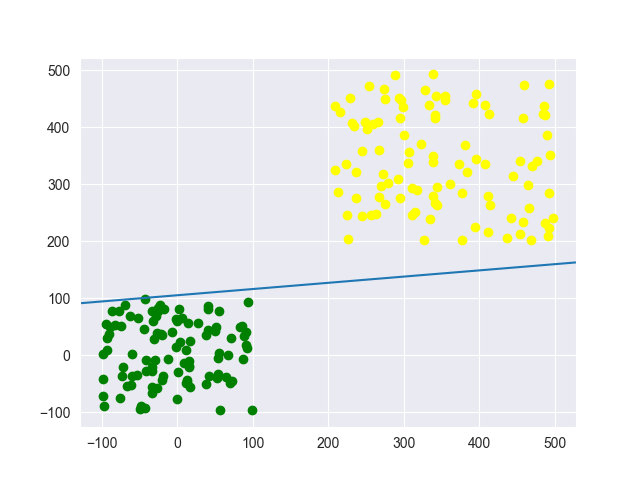

In [141]:
visualize(groups, result_gr[0][0][0][1])

Подчёркнутые в предыдущей серии сообенности поведения касательно времени, сохраняются и в данных испытаниях. Однако же, данный пример примечателен другой своей особенностью. В силу особенностей функции ошибки, наиболее эффективным не только с вычислительной,точки зрения, но и согласно итоговой точности, оказался SGD с кропом 1.<p>
Последней из тестовых выборок для данного сегмента будет являться **датасет регрессии**. Задача - определение расхода топлива на милю по характеристикам машины.

In [11]:
import pandas as pd
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)
dataset = raw_dataset.copy()
dataset = dataset[['Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin', 'MPG']]
dataset = dataset.dropna()
data_normal=(dataset-dataset.mean())/dataset.std()
data_normal.tail()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin,MPG
393,-0.862911,-0.519972,-0.479835,-0.220842,0.021267,1.634321,-0.715726,0.455359
394,-0.862911,-0.930889,-1.363154,-0.997859,3.283479,1.634321,0.525711,2.633448
395,-0.862911,-0.567753,-0.531795,-0.803605,-1.428605,1.634321,-0.715726,1.095974
396,-0.862911,-0.711097,-0.661694,-0.415097,1.108671,1.634321,-0.715726,0.583482
397,-0.862911,-0.720653,-0.583754,-0.303253,1.398646,1.634321,-0.715726,0.967851


Прежде чем переёти непосредственно к регресии, ознакомимся с данными самостоятельно. Для этого построим парные графики для наиболее интересных нам значений. Заметим, что распределения имеют скорее параболический вид, что делает ещё более интересным рассмотрение возможности приближения данного распределение линейным представлением

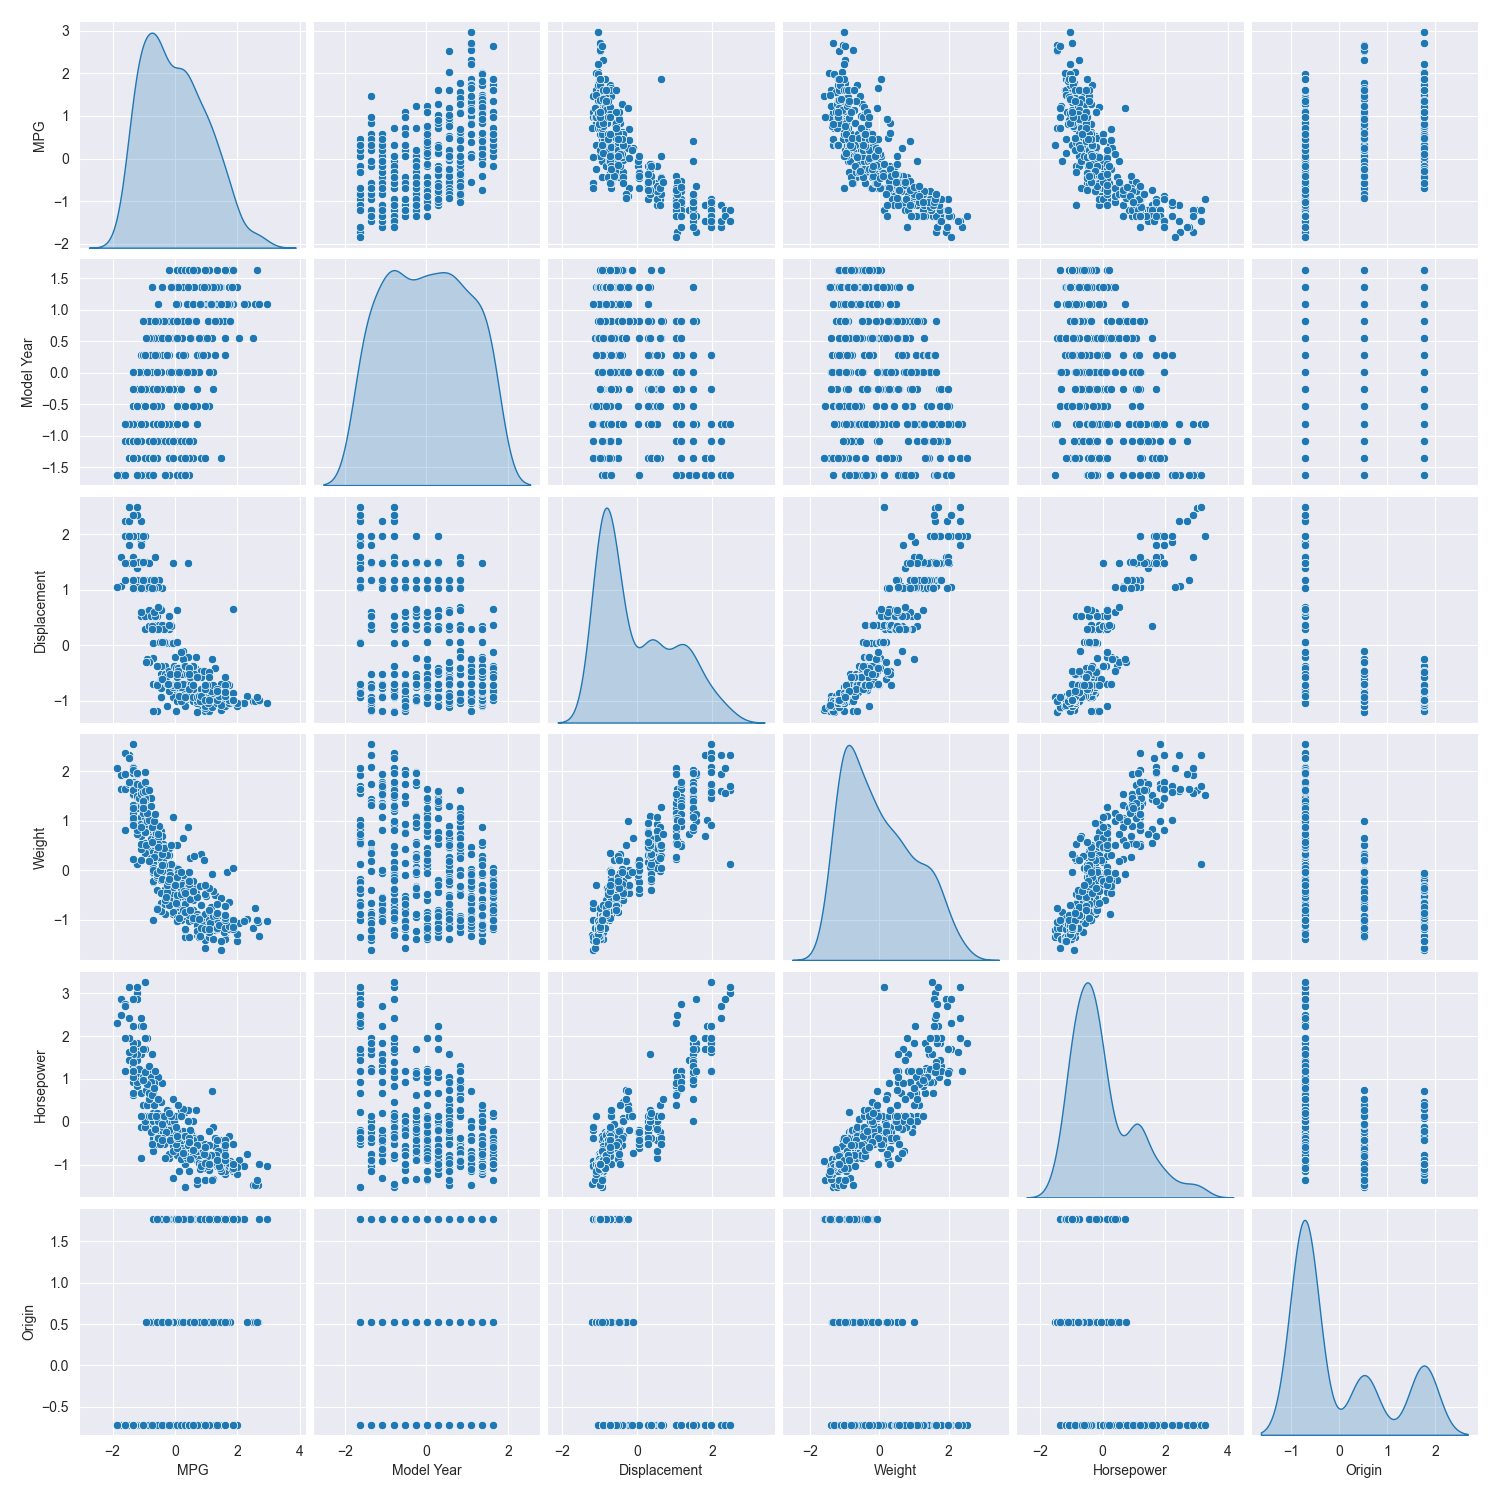

In [12]:
sns.pairplot(data_normal[['MPG', 'Model Year', 'Displacement', 'Weight', 'Horsepower', 'Origin']], diag_kind='kde')

In [13]:
data_normal_np = data_normal.to_numpy()
mpg_regress = MinimisingOracul(MSE(), MultiLinearInterpretation(7), data_normal_np, 30)
result = Runner.run([GradientDescent(learning_rate=100, aprox_dec=1e-11)], [mpg_regress], np.array([1, 1, 1, 1, 1, 1, 1, 1]), modules, precision=defPrec,
                    # **FULL_DEBUG,
                    **TABLE,
                    #**VISUALIZE,
                    # **FULL_VISUALIZE,
                    # **FULL_ANIMATION,
                    #**VISUALIZE_FUNCTION
                    )


MinimisingOracul
+--------------------------------------------------+-----------------+-------------+--------------+-------------+---------------------+-------------+
| Method name                                      |   ExecutionTime | RAMSize     |   EpochCount |   CallCount |   GradientCallCount |   LossValue |
+==================================================+=================+=============+==============+=============+=====================+=============+
| GradientDescent(100,GoldenRatioMethod,eps=1e-11) |         85.0824 | 0.296875 Mb |           30 |       27300 |                 420 |    0.195555 |
+--------------------------------------------------+-----------------+-------------+--------------+-------------+---------------------+-------------+


C:\Users\12345\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


Визуализация семимерного пространства, по очевидным причинам, видится затруднительной, потому, как и при расссмотрении данных, попробуем взглянуть на двумерную проекцию результатов

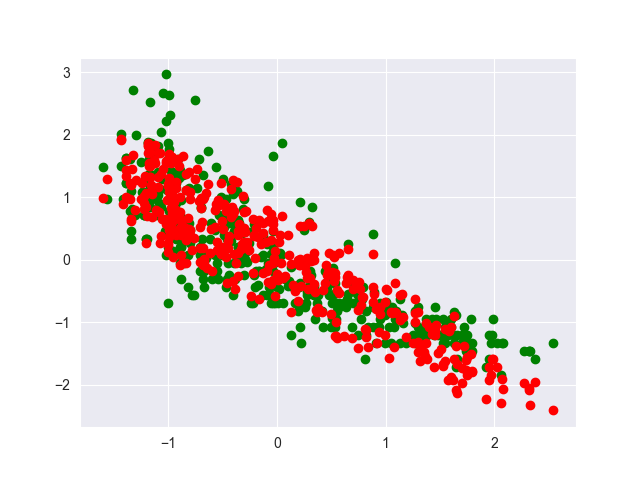

In [14]:
def get_prediction(res, point, ind):
    return point[ind], MultiLinearInterpretation(7).interpret(res, point)[-1]
def print_some(name, res, ind):
    x = data_normal[name]
    y = data_normal['MPG']
    axes = plt.figure().add_subplot()
    points_x = []
    points_y = []
    for i in data_normal_np:
        t_x, t_y = get_prediction(res, i[0:7], ind)
        points_x += [t_x]
        points_y += [t_y]
    axes.scatter(x, y, c ="green")
    axes.scatter(points_x, points_y, c ="red")
    plt.show()
    plt.close()
print_some('Weight', result[0][0][0][1], 3)

Несложно заметить как линейный паттерн распределния результатов, так и сходность очетаний предсказываемыз величин и реальных. В совокупности с весьма малым значением функции лосса и рассмотрением других проекций (не представленных в данном отчёте ввиду меньшей их значимости и в угоду большей компактности), это позволяет сделать заключение об успешном выполнении алгоритмом своих задач на массиве реальных данных. Что немаловажно, ввиду его простоты, мы можем понять, какие данные наиболее значимы для предсказываемого значения

In [15]:
result[0][0][0][1]

array([-0.08663195,  0.25435826, -0.1133819 , -0.722111  ,  0.06719983,
        0.38367943,  0.21790827,  0.02403866])

Несложно заметить, что наиболее важным алгоритму видится вес автомобиля (притом берётся он с отрицательным коэффициентом) - подобныя зависимость, если задуматься, весьма очевидна, заметна она и на графиках совместного распределения, тем не менее, тот факт, что модель распознала подобную закономерность видится примечательным. Менее тривиальную зависимость можно заметить в параметре под номером 5. Он соответствует году выпуска. При обращении к парным распределениям, вновь можно заметить тенденцию роста показателя MPG с увеличением года выпуска. Остальные же параметры вносят вклад не столь значительный (а страна выпуска или число цилиндров - так и вовсе почти не влияют на результат). Таким образом, даже столь примитивная модель может быть полезна в выявлении закономерностей.

Использованные ранее датасеты, ввиду довольно полного покрытия ими задач линейной регрессии, будут и далее служить нам мерилом эффективности при рассмотрении различных модификаций метода SGD, исследованию коего и посвящена данная работа. Хотя, конечно, для внесения минимального разнообразия, там, где это возможно и осмысленно, в рассматриваемые задачи будут внесены изменения

**Перейдём ко второму подпункту основного задания**. В качестве функций изменения шага рассмотрим ступенчатую (ladder_sheduler) и вариации экспоненциального затухания. Также в список рассматриваемых функций добавлен GradientDescentBase, работающий с неизменным learning_rate. Он будет служить основой для дальнейших наблюдений и соображений.

In [16]:
def epoch_sheduler(base_rate, state, decay):
    return base_rate * (1 /(1 + decay * state.epoch))
def step_sheduler(base_rate, state, decay, steps):
    return base_rate * (1 /(1 + decay * ((state.epoch * steps) + state.step)))
def ladder_sheduler(base_rate, state):
    if (state.epoch >= 10):
        return base_rate / 10
    if (state.epoch >= 20):
        return base_rate / 100
    return base_rate


MinimisingOracul
+----------------------------------------+-----------------+---------------+--------------+-------------+---------------------+-------------+
| Method name                            |   ExecutionTime | RAMSize       |   EpochCount |   CallCount |   GradientCallCount |   LossValue |
+========================================+=================+===============+==============+=============+=====================+=============+
| GradientDescentBase(1, eps=0.0001)     |         8.51999 | 0.0625 Mb     |           30 |           0 |                 150 | 1.92018e+11 |
+----------------------------------------+-----------------+---------------+--------------+-------------+---------------------+-------------+
| GradientDescentScheduled(1,eps=0.0001) |         8.36201 | 0.125 Mb      |           30 |           0 |                 150 | 5.18509e+11 |
+----------------------------------------+-----------------+---------------+--------------+-------------+---------------------+---

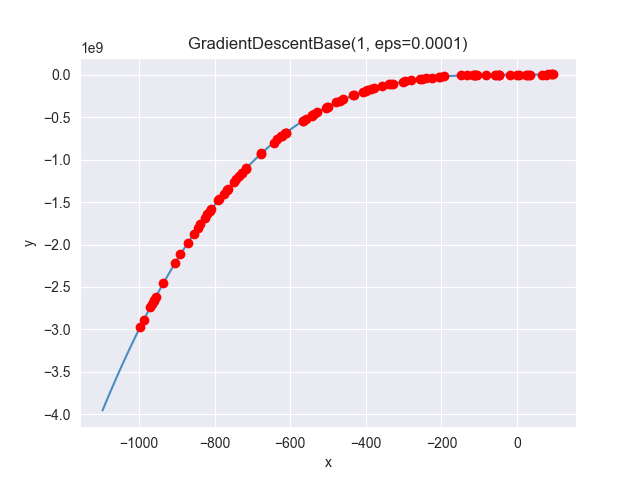

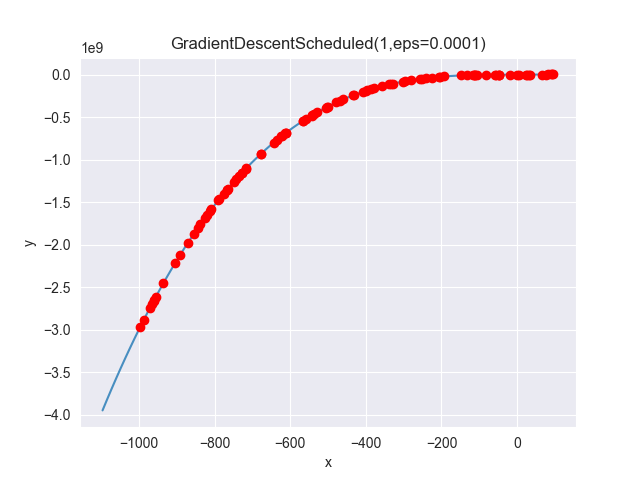

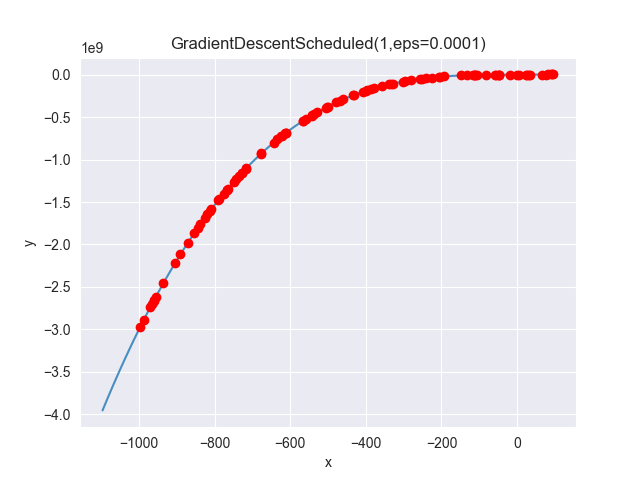

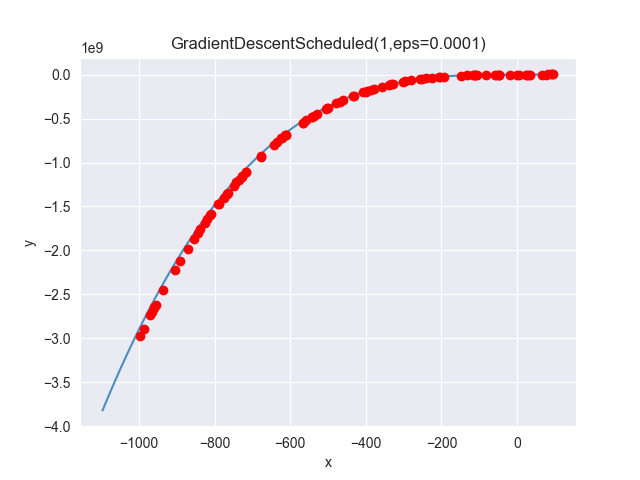

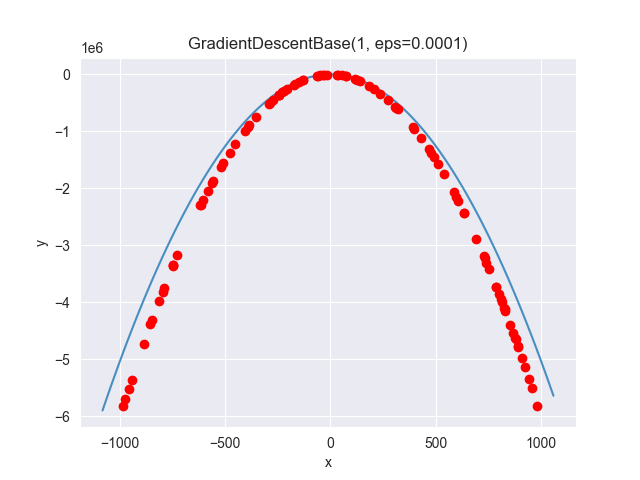

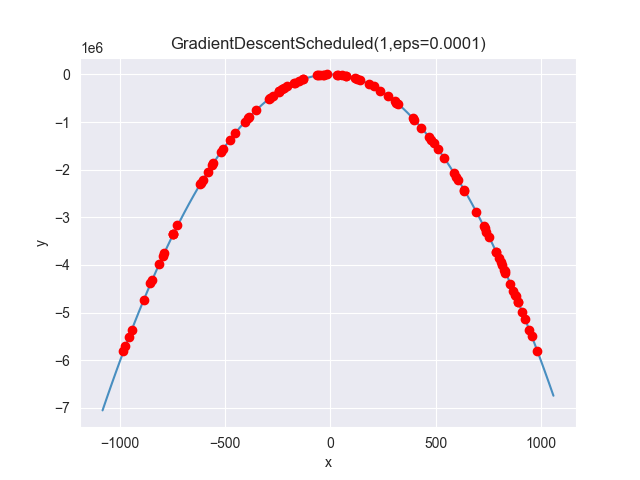

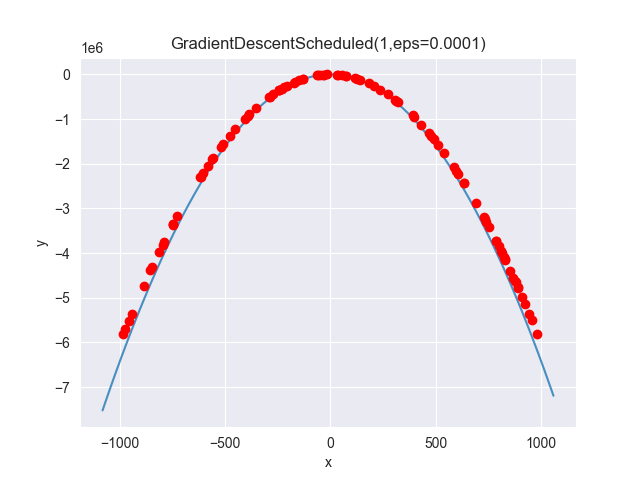

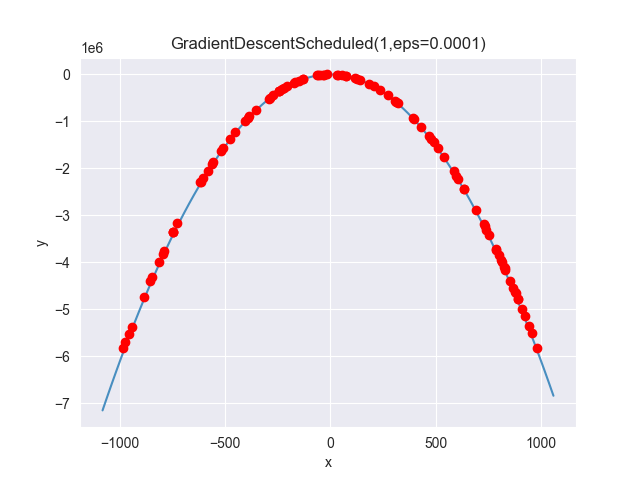

In [17]:
sheduled = [GradientDescentBase(),
           GradientDescentSheduled(lambda a, b: epoch_sheduler(a, b, 0.5), 1),
           GradientDescentSheduled(lambda a, b: step_sheduler(a, b, 0.01, 5), 1),
           GradientDescentSheduled(lambda a, b: ladder_sheduler(a, b), 1)]
hyperbolic_data = noised_data_generator(lambda x: 3*x**3+2*x**2+10, 100, -1000, 100, 1500)
sq_data1 = noised_data_generator(lambda x: -6*x**2-10*x+1, 100, -1000, 1000, 100)
polynomial_oracul_1 = MinimisingOracul(MSE(), PolynomialInterpretation(), sq_data1, 20)
hyperbolic_oracul = MinimisingOracul(MSE(), HyperbolicInterpretation(), hyperbolic_data, 20)
result = Runner.run(sheduled, [hyperbolic_oracul, polynomial_oracul_1], np.array([1, 1, 1, 1]), modules, precision=defPrec,
                 # **FULL_DEBUG,
                 **TABLE,
                 **VISUALIZE,
                 # **FULL_VISUALIZE,
                 # **FULL_ANIMATION,
                 **VISUALIZE_FUNCTION
                 )

При всех стратегиях изменения шага обучения модели показали улучшение точности предсказаний. Тем не менее, можно заметить, что различные стратегии привели к разной точности вычисления. Подобное легко объяснимо тем, что они предназначены для различных задач и поведения модели. Более подробно данная тема будет рассмотрена после второй серии экспериментов.<p>
Также немаловажным является тот факт, что подобное управление шагом обучения не влияет на время обучения модели. Показатели же, достигаемые ими, сравнимы с теми, что были у моделей, выбирающих шаг на основе алгоритма золотого сечения

In [18]:
result = Runner.run(sheduled, [mpg_regress], np.array([1, 1, 1, 1, 1, 1, 1, 1]), modules, precision=defPrec,
                 # **FULL_DEBUG,
                 **TABLE,
                 **VISUALIZE,
                 # **FULL_VISUALIZE,
                 # **FULL_ANIMATION,
                 **VISUALIZE_FUNCTION
                 )


MinimisingOracul
+----------------------------------------+-----------------+---------------+--------------+-------------+---------------------+-------------+
| Method name                            |   ExecutionTime | RAMSize       |   EpochCount |   CallCount |   GradientCallCount |   LossValue |
+========================================+=================+===============+==============+=============+=====================+=============+
| GradientDescentBase(1, eps=0.0001)     |         71.5971 | 0.16015625 Mb |           30 |           0 |                 420 |    1.95462  |
+----------------------------------------+-----------------+---------------+--------------+-------------+---------------------+-------------+
| GradientDescentScheduled(1,eps=0.0001) |         70.3402 | 0.01171875 Mb |           30 |           0 |                 420 |    0.191058 |
+----------------------------------------+-----------------+---------------+--------------+-------------+---------------------+---

C:\Users\12345\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


Заметим, что некоторые стратегии, показавшие себя не лучшим образом в предыдущем случае, оказались эффективны при работе на реальных данных. Подобный эффект в значительной степени ожидаем. В зависимости от сложности задачи, может быть предпочтительным различное поведение шага обучения. Так, большой шаг на старте может помочь быстрее добраться в окрестность минимума или перескочить локальные, однако же для получения более точного значения требуется меньшее значение шага. Так же большое значение шага может вести к серьёзным колебаниям функции потерь в процессе обучения. Потому, для наиболее точного и быстрого схождения алгоритмов подобного класса, требуется подбирать функцию изменения шага для конкретной задачи и специфики схождения в ней. <p>
Тем не менее, проведённые эксперименты позволяют предположить, что во многих случаях довольно эффективна будет стратегия экспоненциального изменения. Данная стратегия так же применяется в качестве базовой библиотекой keras

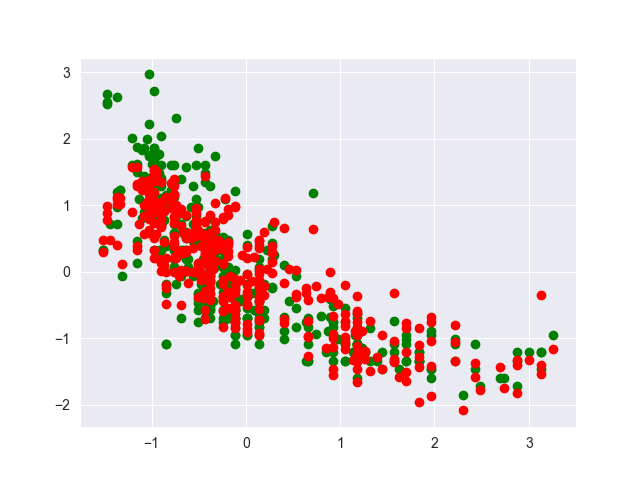

In [19]:
print_some('Horsepower', result[0][1][0][1], 2)

Перейдём наконец к сравнению различных модификаций метода SGD. Для этого будет использована библиотека tensorflow. Выбор связан как с её простотой, так и с наиболее широким выборов функций класса SGD в сравнении с аналогичными библиотеками (в частности, sklearn, pyTorch, scipy), что является крайне важным фактором в рамках данной работы

Для наблюдения особенностей поведения методов, будем использовать набор данных по предсказанию MPG и сгенерированные зашумлённые данные для предсказания прямой по переменной x

In [20]:
temp1 = np.array(linear_data).transpose()[0:1].transpose()
temp2 = np.array(linear_data).transpose()[1]
data_normal_np_x = data_normal_np.transpose()[0:7].transpose()
data_normal_np_y = data_normal_np.transpose()[7]

In [21]:
import tensorflow as tf
def fit_model(model, optimizer, x, y, epoch, batch_size):
    s_t = time.time()
    #model.load_weights('default.weights.h5')
    model.compile(optimizer=optimizer, loss='mean_absolute_error')
    history = model.fit(x, y, epochs=epoch, batch_size=batch_size, callbacks=[tf.keras.callbacks.ModelCheckpoint(optimizer + "_best.keras")], verbose=0, validation_split = 0.2)
    model.load_weights(optimizer + "_best.keras")
    print("Training time: ", time.time() - s_t)
    print("Best params: ", model.layers[0].get_weights())
    return history

В качестве модели будет использована нейронная сеть с одним нейроном и bias в качесвте обучаемого параметра. Подобное задание полностью эквивалентно тому, что было представлено нами при решении данной проблемы ранее.

В качестве же модификаций метода SGD будут рассмотрены *Adam*, *Adagrad*, *RMSProp*, кроме того, в качестве точки опоры будет рассмотрен и сам метод SGD, представленный в библиотеке Tensorflow. Работоспособность библиотеки не вызывает сомнений, потому дабы не смотреть на очередной трививальный пример, а сравнить вместо этого большее число методов, начнём сразу с содержательного случая. призванного проверить эффективность метода на реальных данных.

In [31]:
linear_model_sgd = tf.keras.Sequential([
        tf.keras.layers.Input((7,)),
        tf.keras.layers.Dense(units=1, use_bias=True)
    ])
hist_sgd = fit_model(linear_model_sgd, 'sgd', data_normal_np_x, data_normal_np_y, 50, 20)

Training time:  3.3460097312927246
Best params:  [array([[-0.04922151],
       [-0.13626404],
       [ 0.10360888],
       [-0.53432316],
       [-0.0427896 ],
       [ 0.23309414],
       [ 0.05917851]], dtype=float32), array([-0.10930771], dtype=float32)]


In [32]:
linear_model_adam = tf.keras.Sequential([
        tf.keras.layers.Input((7,)),
        tf.keras.layers.Dense(units=1, use_bias=True)
    ])
hist_adam = fit_model(linear_model_adam, 'adam', data_normal_np_x, data_normal_np_y, 50, 20)

Training time:  3.3910062313079834
Best params:  [array([[ 0.4578392 ],
       [-1.0678126 ],
       [ 0.53906864],
       [-0.23014222],
       [ 0.32930857],
       [ 0.10645381],
       [ 0.13149005]], dtype=float32), array([-0.18408361], dtype=float32)]


In [51]:
linear_model_rmsprop = tf.keras.Sequential([
        tf.keras.layers.Input((7,)),
        tf.keras.layers.Dense(units=1, use_bias=True)
    ])
hist_rmsprop = fit_model(linear_model_rmsprop, 'rmsprop', data_normal_np_x, data_normal_np_y, 50, 20)

Training time:  3.40500807762146
Best params:  [array([[-0.02540317],
       [-0.08328868],
       [-0.78398705],
       [-0.05546573],
       [-0.39601365],
       [ 0.14302324],
       [ 0.06728303]], dtype=float32), array([-0.15835595], dtype=float32)]


In [49]:
linear_model_adagrad = tf.keras.Sequential([
        tf.keras.layers.Input((7,)),
        tf.keras.layers.Dense(units=1, use_bias=True)
    ])
hist_adagrad = fit_model(linear_model_adagrad, 'adagrad', data_normal_np_x, data_normal_np_y, 50, 20)

Training time:  3.396061658859253
Best params:  [array([[ 0.4986002 ],
       [-0.6351646 ],
       [-0.23964271],
       [-0.80452543],
       [-0.61829513],
       [ 0.71192306],
       [ 0.25911984]], dtype=float32), array([0.02569786], dtype=float32)]


Сразу заметим, что наибольшее время для своего исполнения требуют алгоритмы *AdaGrad* и *RMSProp*, наименьшее - *SGD* и *Adam*. Модификации алгоритма *SGD* имеют несколько основных целей: ускорение обучения, избегание локальных минимумов, ускорение вычислений.

In [26]:
def plot_loss(history):
  axes = plt.figure().add_subplot()
  axes.plot(history.history['loss'], label='loss')
  axes.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  axes.legend()
  axes.grid(True)
  plt.show()

Как сами данные, так и результаты работы функции при сходных значениях итоговой функции ошибки уже демонстрировались ранее, кроме того, финальный результат работы функций малоинформативен, потому рассмотрим работу на графиках функций потерь

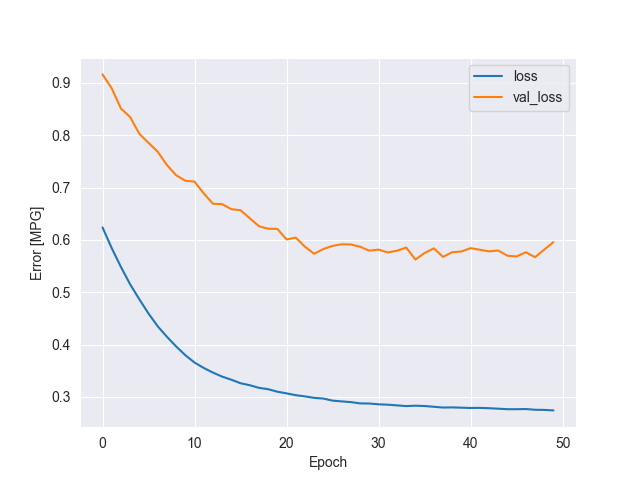

In [36]:
plot_loss(hist_sgd)

Сначала рассмотрим уже привычный и знакомый нам по предыдущим сериям SGD. Значение функции лосса достаточно быстро падает, однако разбиение датасета на набор для тренировки и валидации позволяет заметить проблему: в некоторый момент падение *val_loss* прекратилось. Это позволяет предположить, что можель перестала обучаться видеть глобальные закономерности, подгоняя свои коэффициенты для конкретных данных. Во многом именно данную проблему призваны решить модификации

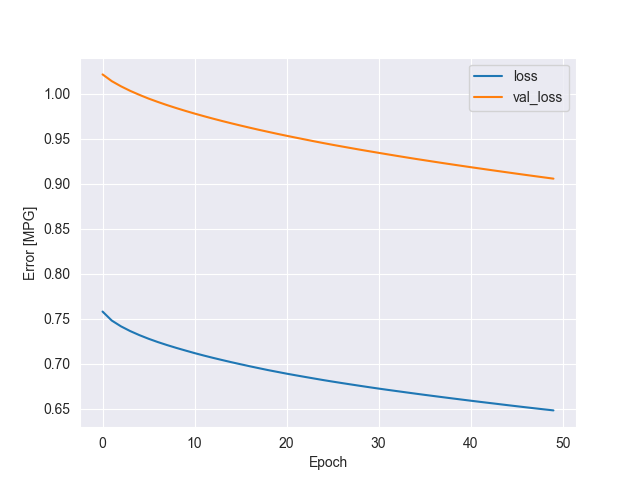

In [81]:
plot_loss(hist_adagrad)

Особенность *Adagrad* заключается в том, что при обновлении параметров учитывается частота их обновлении в прошлом. Чем чаще обновляется параметр - тем меньше величина его обновления. Как моэно заметить, подобное препятствует переобучению модели, хотя и требует как дополнительных вычислений, так и памяти. Тем не менее, при малом числе параметров, это существенно тормозит обучение модели (более того, может привести к полной остановке обучения), как можно заметить на данном примере. В некоторой степени, подобная проблема может быть решена повышением значения learning_rate, тем не менее, данный набор данных не имеет критически важных экзотических признаков, чтобы применение Adagrad имело существенный смысл.

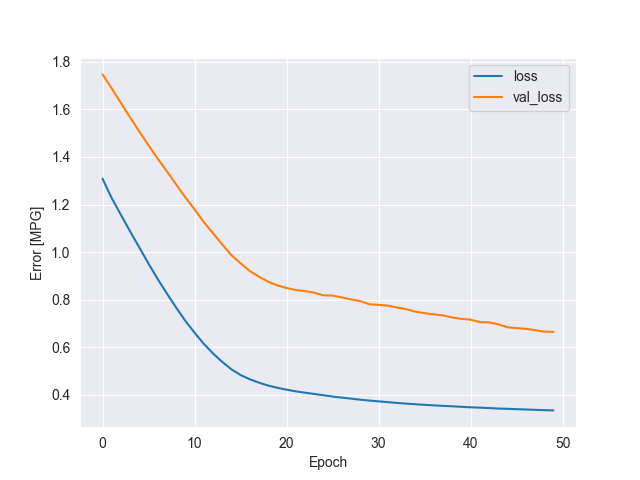

In [82]:
plot_loss(hist_rmsprop)

*RMSProp* в некотором смысле явялется модификацией *Adagrad*, призванный исправить проблему остановки или существенного замедления обучения при слишком частом обновлении одних и тех же параметров. Как и *Adagrad*, потребляет существенное количество памяти и требует большего, нежели более примитивные методы, времени для вычисления. Однако, как можно заметить, весьма успешно справляется с поставленными перед ним задачами. Достигается это экспоненциально затухающим убывающим средним, использованным для вычисления коэффициентов обновления параметров.

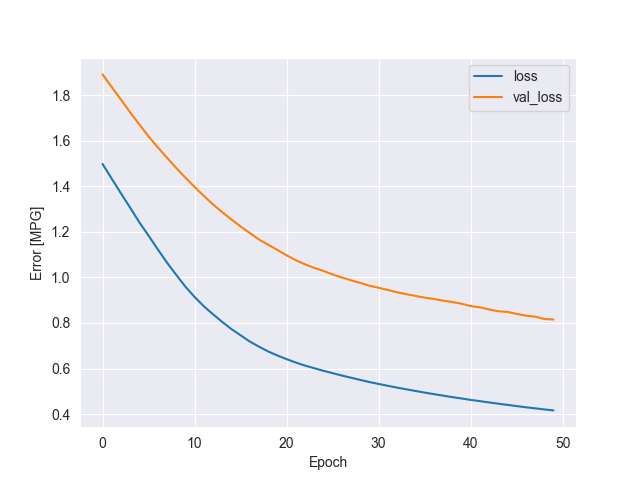

In [83]:
plot_loss(hist_adam)

Adam использует в своих вычислениях моменты первого и второго порядка. Сочетает в себе и идею накопления движения, и идею более слабого обновления весов для типичных признаков. Результаты работы видятся наиболее эффективными в сравнении с другими алгоритмами